In [47]:
from charm.toolbox.pairinggroup import PairingGroup, ZR, G1, G2, GT, pair
from charm.toolbox.ABEnc import ABEnc
from charm.toolbox.msp import MSP

import random, time
import matplotlib.pyplot as plt

## Helper Function

In [3]:
# k refers to k-lin, but also decides the size of vector
def gen_Z_p(k, groupObj = PairingGroup('MNT224')):
    group = groupObj
    vec = []
    if k == 1:
        return group.random(ZR)
    
    for i in range(k):
        vec.append(group.random(ZR))
    
    return vec

# n refers to number of AA here
# Generate a random oracl that only return constant value for each AA_i
# @update: Use group.hash(), maps to Z_p^{k+1}
def rand_oracle(n, k, groupObj = PairingGroup('MNT224')):
    group = groupObj

    H = {}
    for i in range(n):
        for j in range(i, n):
            H[str(i+1)+str(j+1)] = gen_Z_p(k+1,group)
    
    return H


In [4]:
# i refers to the index in the total n AA
# k refers to k-lin assumption
def gen_mu_i(i, n, k, H, groupObj = PairingGroup('MNT224')):
    group = groupObj
    mu = [0] * (k+1)
    for j in range(1, i):
        mu = [x + y for x,y in zip(mu, H[str(j)+str(i)])]

    if i == n:
        return mu

    for j in range(i+1,n+1):
        mu = [x - y for x,y in zip(mu, H[str(i)+str(j)])]

    return mu

def gen_mus(n,assump_size, groupObj = PairingGroup('MNT224')):
    group = groupObj
    mus = {}
    k = assump_size

    H = rand_oracle(n,k)
    h = []

    for i in range(n):
        mus[str(i+1)] = gen_mu_i(i+1,n,k,H)
    
    for i in range(k+1):
        h.append(group.random(ZR))
    
    return mus, h, H

def vrf_mus(mu_list, k):
    n = len(mu_list)
    s = [0] * (k+1)

    for i in range(n):
        s = [x + y for x,y in zip(s, mu_list[i])]

    print (s)

In [5]:
def prod(iterable, type = 'scalar'):
    if type == 'scalar':
        result = 1
        for item in iterable:
            result *= item

        return result
    
    if type == 'vector':
        result = [prod(values) for values in zip(*iterable)]
        return result

In [6]:
def transpose(matrix):
    # If it's a vector, convert to a 1xN matrix
    if not isinstance(matrix[0], list):
        matrix = [matrix]
    
    # Transpose the matrix
    transposed = [[row[i] for row in matrix] for i in range(len(matrix[0]))]
    
    return transposed

def mul_matrices(A, B):
    # Check if B is a vector
    if not isinstance(B[0], list):
        result = [sum(A[i][j] * B[j] for j in range(len(B))) for i in range(len(A))]
    else:  # B is a matrix
        result = [[sum(A[i][j] * B[j][k] for j in range(len(B))) for k in range(len(B[0]))] for i in range(len(A))]

    return result

def add_matrices(A, B):
    # Check if they are vectors (1D) or matrices (2D)
    if isinstance(A[0], list) and isinstance(B[0], list):  # Both are matrices
        if len(A) != len(B) or len(A[0]) != len(B[0]):
            raise ValueError("Matrices dimensions do not match")
        return [[A[i][j] + B[i][j] for j in range(len(A[0]))] for i in range(len(A))]
    elif not isinstance(A[0], list) and not isinstance(B[0], list):  # Both are vectors
        if len(A) != len(B):
            raise ValueError("Vectors lengths do not match")
        return [A[i] + B[i] for i in range(len(A))]
    else:
        raise ValueError("Incompatible dimensions: One is vector, the other is matrix")

def subtract_matrices(A, B):
    # Check if they are vectors (1D) or matrices (2D)
    if isinstance(A[0], list) and isinstance(B[0], list):  # Both are matrices
        if len(A) != len(B) or len(A[0]) != len(B[0]):
            raise ValueError("Matrices dimensions do not match")
        return [[A[i][j] - B[i][j] for j in range(len(A[0]))] for i in range(len(A))]
    elif not isinstance(A[0], list) and not isinstance(B[0], list):  # Both are vectors
        if len(A) != len(B):
            raise ValueError("Vectors lengths do not match")
        return [A[i] - B[i] for i in range(len(A))]
    else:
        raise ValueError("Incompatible dimensions: One is vector, the other is matrix")

def power_mul(A, B, type = 'matrix'):
    if type == 'v_scalar':
        result=[]
        for elem in A:
            # print ('new elem:')
            # print (elem)
            result.append(elem ** B)
        return result

    if type == 'm_scalar':
        return [[elem ** B for elem in row] for row in A]
    
    if type == 'v_vector':
        if len(A) != len(B):
            raise ValueError("Number of elements in A must be equal to number of elements in B")

        return prod([a ** b for a,b in zip(A,B)])
    
    if type == 'm_vector':
        # print (A[0])
        # print (B)
        if len(A[0]) != len(B):
            raise ValueError("Number of columns in A must be equal to number of elements in B")
        
        result = [1] * len(A)

        for i in range(len(A)):
            for j in range(len(B)):
                result[i] *= A[i][j] ** B[j]
        return result

    result = [[1 for _ in range(len(B[0]))] for _ in range(len(A))]
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                result[i][j] *= A[i][k] ** B[k][j]

    return result

## System & Auth Setup

In [7]:
# for given size k
def sys_setup(assump_size, groupObj = PairingGroup('MNT224')):
    k = assump_size
    group = groupObj

    # Generate Pub Param
    A = []
    for i in range(k):
        A.append(group.random(ZR))

    '''
    a_1  0   0   0   0
    0   a_2  0   0   0
    0    0  a_3  0   0
    0    0   0  a_4  0
    0    0   0   0  a_5
    1    1   1   1   1
    '''
    # a special vector to make A^T.dot(a) = 0
    # a = [1/a_1 1/a_2 1/a_3 1/a_4 1/a_5 -1]
    a = []
    for i in range(assump_size):
        a.append(1/A[i])
    a.append(-1)

    U = []
    for j1 in range(k + 1): #col
        y = []
        for j2 in range(k + 1): #row
            y.append(group.random(ZR))
        U.append(y)

    g = group.random(G1)
    h = group.random(G2)
    e_gh = pair(g,h)

    g_A = []
    for j in range(k):
        g_A.append(g**A[j])

    g_UTA = []
    for j1 in range(k+1): #col
        y = []
        for j2 in range(k): #row
            prod = (A[j2] * U[j2][j1] + U[k][j1])
            y.append(g ** prod)
        g_UTA.append(y)    

    pp = {'g_1': g, 'g_2': h, 'e_g1_g2':e_gh, 'g_1^A': g_A, 'g_1^{U^T A}': g_UTA}
    msk = {'A': A, 'U': U, 'a': a}
    return pp, msk

In [8]:
def gen_pk_sk(pp, assump_size, groupObj = PairingGroup('MNT224')):
    k = assump_size
    group = groupObj

    g = pp['g_1']
    h = pp['g_2']
    e_gh = pp['e_g1_g2']
    g_A = pp['g_1^A']

    X = [] # random samples <- F_p^{(k+1) * (k+1)}
    for j1 in range(k + 1): #col
        y = []
        for j2 in range(k + 1): #row
            y.append(group.random(ZR))
        X.append(y)

    tau = []
    for i in range(k+1):
        tau.append(group.random(ZR))

    sigma = group.random(ZR)

    g_XTA = []
    for j1 in range(k+1):
        y = []
        for j2 in range(k):
            y.append(g_A[j2]**X[j2][j1] * g ** X[k][j1])
        g_XTA.append(y)

    e_gAh = []
    for i in range(k):
        e_gAh.append(pair(g_A[i],h))
    e_gAh.append(e_gh)

    e_gh_tauTA = []
    for i in range(k):
        e_gh_tauTA.append(e_gAh[i]**tau[i] * e_gh**tau[k])

    y = h**sigma

    pk = {'g_1^{X^T A}': g_XTA, 'e(g_1,g_2)^{tau^T A}': e_gh_tauTA, 'y': y}
    sk = {'X': X, 'tau': tau, 'sigma': sigma}
    return pk, sk

def auth_setup(n, pp, assump_size, groupObj = PairingGroup('MNT224')):
    pks = {}
    sks = {}

    for i in range(n):
        pk, sk = gen_pk_sk(pp, assump_size, groupObj)
        #print (pk)
        pks[str(i+1)] = pk
        sks[str(i+1)] = sk

    return pks, sks

## Key Generation

In [9]:
def gen_x_v(n, assump_size, authorized = [],groupObj= PairingGroup('MNT224')):
    k = assump_size
    group = groupObj

    if not authorized:
        size = random.randint(1,n-2)
        authorized = random.sample(range(n-1), size)

    #print (authorized)
    vec_x = [0] * n
    vec_v = [0] * n

    for index in authorized:
        if index == authorized:
            print ('incorrect index to be ', n)
            continue

        vec_x[index] = group.random(ZR)
        vec_v[index] = 1

    vec_x[-1] = -sum(vec_x[:-1])
    vec_v[-1] = 1

    return vec_x, vec_v

In [10]:
# @todo, g_2^h not real implemented
def gen_keys(pp, n, sks, vec_v, assump_size):
    k = assump_size
    g2 = pp['g_2']

    mus,h, _ = gen_mus(n, assump_size)
    # mu_list = []
    # for i in range(n):
    #     mu_list.append(mus[str(i+1)])
    # print (vrf_mus(mu_list, k))

    K = {}

    for i in range(n):
        #pk = pks[str(i+1)]
        sk = sks[str(i+1)]
        v = vec_v[i]
        mu = mus[str(i+1)]


        X = sk['X']
        tau = sk['tau']

        tmp = mul_matrices(X, h)
        #print (len(mu))
        exponent = [x - v * y for x,y in zip(tau, tmp)]
        exponent = [x + y for x,y in zip(exponent, mu)]
    
        K_i = []
        #print (len(exponent))
        for j in range(k+1):
            K_i.append(g2 ** exponent[j])

        K[str(i+1)] = K_i
        #print (len(h))
        K['g_2^h'] = [g2 ** ele for ele in h]

    return K


## Encryption





In [11]:
def encrypt(pp, pks, vec_x, M, assump_size, groupObj = PairingGroup('MNT224')):
    k = assump_size
    group = groupObj
    n = len(pks)

    g = pp['g_1']
    h = pp['g_2']
    e_gh = pp['e_g1_g2']
    g_A = pp['g_1^A']
    g_UTA = pp['g_1^{U^T A}']

    vec_s = []
    for i in range(k):
        vec_s.append(group.random(ZR))

    #print (vec_x)

    C_0 = []
    for i in range(k):
        C_0.append(g_A[i] ** vec_s[i])
    C_0.append(g ** sum(vec_s))
    #C_0 = power_mul(g_A, vec_s, type='vector')

    C_i = []
    for i in range(n):
        g_XTA = pks[str(i+1)]['g_1^{X^T A}']
        g_UTAs = power_mul(g_UTA, vec_s, type='m_vector')
        
        if vec_x[i] != 0:
            tmp = power_mul(g_UTAs, vec_x[i], type = 'v_scalar')
        else:
            tmp = [1] * (k+1)
            
        tmp2 = power_mul(g_XTA, vec_s, type = 'm_vector')
        #print (len(tmp), len(tmp2))
        C_i.append([x * y for x,y in zip(tmp, tmp2)])

    C_ = M
    #print (M)
    for i in range(n):
        e_gh_tauTA = pks[str(i+1)]['e(g_1,g_2)^{tau^T A}']
        #print (e_gh_tauTA)
        C_ = C_ * power_mul(e_gh_tauTA, vec_s, type = 'v_vector')

    C = {'C_0': C_0, 'C_i': C_i, 'C':C_}
    return C, vec_s
   

## Decryption

In [12]:
def decrypt(K, C, vec_v, n, pp, groupObj = PairingGroup('MNT224')):
    H = K['g_2^h']
    group = groupObj

    g1 = pp['g_1']
    g2 = pp['g_2']

    C_i_s = C['C_i']
    C_0 = C['C_0']
    ciphertext = C['C']

    K_ = K['1']
    C_ = C_i_s[-1]
    #print (len(C_))
    for i in range(1, n):
        K_ = [x * y for x,y in zip(K_, K[str(i+1)])]

        if vec_v[i-1]:
            #print (len(C_i_s[i-1]))
            C_ = [x * y for x,y in zip(C_, C_i_s[i-1])]

    #print (len(H), len(C_),len(C_0), len(K_))
    e_gh_C_0 = [pair(x, y) for x,y in zip(C_0, K_)]
    e_gh_C_i = [pair(x, y) for x,y in zip(C_, H)]
    #print ('cancel out?')
    #print (e_gh_C_i)

    rst = e_gh_C_0[0] * e_gh_C_i[0]
    #print (H, C_)
    for i in range(1, len(e_gh_C_0)):
        rst = rst * e_gh_C_0[i] * e_gh_C_i[i]
    #print (rst)
    #return rst
    return ciphertext/rst
    


### Sum up

In [15]:
n = 10
assump_size = 3
group = PairingGroup('MNT224')

pp, msk = sys_setup(assump_size)
vec_x, vec_v = gen_x_v(n, assump_size)

pks, sks = auth_setup(n, pp, assump_size)

print ('Authorized list: ', vec_v)
K = gen_keys(pp, n, sks, vec_v, assump_size)

M = group.random(GT)
print ('M:', M)
C,vec_s = encrypt(pp, pks, vec_x, M, assump_size)

M_ = decrypt(K, C, vec_v, n, pp)

print ('M_:', M_)


Authorized list:  [0, 1, 1, 1, 1, 1, 0, 1, 1, 1]
M: [[12029247237542470655070469813336047652391494497937984565405725687422, 10100347900403318239448290668293845246309784322083086304530701247127, 5220631751826488435813497306893426616742106140351741712241017167873], [8926875639907496247589655425232993800141122254200865849376590246231, 10046442242167048021627996901185422687788885118753452954815166401056, 192327049870465529353214257192888725808579380431393271453118317338]]
M_: [[12029247237542470655070469813336047652391494497937984565405725687422, 10100347900403318239448290668293845246309784322083086304530701247127, 5220631751826488435813497306893426616742106140351741712241017167873], [8926875639907496247589655425232993800141122254200865849376590246231, 10046442242167048021627996901185422687788885118753452954815166401056, 192327049870465529353214257192888725808579380431393271453118317338]]


## Rogue-key Attack

In [16]:

def ad_auth_setup(n, assump_size, ad, pks):

    pk_ad = []
    k = assump_size
    pk_ad = [[1] * k] * (k+1)

    for i in range(n-1):
        if i + 1 == ad:
            continue

        g_XTA = pks[str(i+1)]['g_1^{X^T A}']

        tmp = []
        for j in range(len(g_XTA)):
            tmp.append([x / y for x,y in zip(pk_ad[j], g_XTA[j])])
        
        pk_ad = tmp

    pk = pks[str(ad)]
    pk['g_1^{X^T A}'] = pk_ad
    
    pks[str(ad)] = pk

    return pks
    

In [17]:
def test_ad_auth_setup(n, pks, assump_size):
    k = assump_size
    rst = [[1] * k] * (k+1)
    for i in range(n - 1):
        pk = pks[str(i + 1)]
        g_XTA = pk['g_1^{X^T A}']

        tmp = []
        for j in range(len(g_XTA)):
            tmp.append([x * y for x,y in zip(rst[j], g_XTA[j])])
        
        rst = tmp

    return rst

def test_gen_omega(C, n, pp, K):
    C_i_s = C['C_i']

    tmp_C = [1] * 4
    for i in range(n-1):
        #print (len(tmp_C), len(C_i_s[i]))
        tmp_C = [x * y for x,y in zip(tmp_C, C_i_s[i])]

    x_n = vec_x[-1]
    #print(vec_x)
    g_UTA = pp['g_1^{U^T A}']
    H = K['g_2^h']
    g_UTAs = power_mul(g_UTA, vec_s, type='m_vector')
    g_xUTAs = [x_n * ele for ele in g_UTAs]

    print ([x * y for x,y in zip(tmp_C, g_xUTAs)])

In [18]:
def gen_omega(K, C, n, assump_size):
    H = K['g_2^h']
    k = assump_size
    C_i_s = C['C_i']

    C_ = [1] * (k + 1)
    #C_  = tmp
    for i in range(n-1):
        #print (len(C_), len(C_i_s[i]))
        C_ = [x / y for x,y in zip(C_, C_i_s[i])]

        #print (len(C_))

    return [pair(x,y) for x,y in zip(C_, H)]


### Sum up

In [34]:
n = 10
assump_size = 3

pp, msk = sys_setup(assump_size)
vec_x, vec_v = gen_x_v(n, assump_size)

M = group.random(GT)
print ('M:', M)
print ('Authorized list: ', vec_v)

pks, sks = auth_setup(n, pp, assump_size)

ad = vec_v.index(0) + 1
ad_vec_v = [0] * (n-1) + [1]
print ('Adversary:', ad, '\nVector belongs to AD:', ad_vec_v)
pks = ad_auth_setup(n, assump_size, ad, pks)

K = gen_keys(pp, n, sks, ad_vec_v, assump_size)
C, vec_s = encrypt(pp, pks, vec_x, M, assump_size)

print (decrypt(K, C, vec_v,n,pp))

omega = gen_omega(K, C, n, assump_size)
M_ = decrypt(K, C, ad_vec_v, n, pp)
print ('M_', M_ * prod(omega))

M: [[4715454989982910139568665627786273090210910800119659937792109151050, 6017073235180687859063933798309791416777659727596251887697555346815, 10133445186448362682760764318372469768467660323274851127584443164901], [8940728160695829730334224273934780445857722679397015217613574217984, 3663437602644415675036064371510132275547822800746668075441958375111, 6360988489755978546429873967565165296485472428350735598522962655501]]
Authorized list:  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Adversary: 1 
Vector belongs to AD: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[[13013649739981937113861269314914016741537428523614376785184213957067, 314261689573772395793120697840059991324216417488941342814025356485, 3613065820325406041401464054842033063445558864477209153643873862933], [7074848467835194346383214492154201985516279829950287312493857317078, 6281968272739541388115953487621617657154291623463503928618319396152, 9526920265425787051425425745623112066156543112397620026151227104145]]
M_ [[4715454989982910139568665627786273090

### Testing

In [20]:
test_ad_auth_setup(n, pks, assump_size)

[[O, O, O], [O, O, O], [O, O, O], [O, O, O]]

In [21]:
test_gen_omega(C, n, pp, K)

[O, O, O, O]


## Benchmark

Focue on original scheme compared to the  attack

In [55]:
# MJ's scheme
# @todo, there exist a bug, feels like related to K. Since pks and sks are different
def gen_data(assump_size, list_n, groupObj = PairingGroup('MNT224')):
    k = assump_size
    group = groupObj
    data = []

    for n in list_n:
        sys_cost = []
        ad_cost = []
        # Setup
        start_time = time.time()
        pp, msk = sys_setup(assump_size)
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        sys_cost.append(elapsed_time)
        #ad_cost.append(elapsed_time)

        # Auth Setup
        start_time = time.time()
        pks, sks = auth_setup(n, pp, assump_size)
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        #tmp = elapsed_time
        sys_cost.append(elapsed_time)

        # Key Gen
        start_time = time.time()
        vec_x, vec_v = gen_x_v(n, assump_size)
        K = gen_keys(pp, n, sks, vec_v, assump_size)
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        sys_cost.append(elapsed_time)

        # AD's Auth Setup
        start_time = time.time()
        ad = vec_v.index(0) + 1
        ad_vec_v = [0] * (n-1) + [1]
        pks = ad_auth_setup(n, assump_size, ad, pks)
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        ad_cost.append(elapsed_time)
        
        # Encryption
        start_time = time.time()
        M = group.random(GT)
        #print ('M:', M)
        C, _ = encrypt(pp, pks, vec_x, M, assump_size)
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        sys_cost.append(elapsed_time)

        # Decryption
        start_time = time.time()
        M_ = decrypt(K, C, vec_v,n,pp)
        #print ('M_:', M_)
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        sys_cost.append(elapsed_time)

        # AD decrypt
        start_time = time.time()
        omega = gen_omega(K,C,n,assump_size)
        M_ad = decrypt(K, C, ad_vec_v, n, pp) * prod(omega)
        #print ('M_:', M_ad * prod(omega))
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        ad_cost.append(elapsed_time)

        #print ('total:', sum(sys_cost))
        data.append([sys_cost, ad_cost])
        #return

    return data
    

In [56]:
data_2 = gen_data(2, range(5,30,5))

In [57]:
data_3 = gen_data(3, range(5,30,5))

### Plot

In [76]:
xs = range(5,101,5)
k_values = [2,3]

data_2 = gen_data(2, xs)
data_3 = gen_data(3, xs)

ys = []
ys.append([sum(pair[0]) for pair in data_2])
ys.append([sum(pair[0]) for pair in data_3])

In [91]:
len(data_10)

13

In [87]:
sp_k = [5,10]
sp_xs = range(5,102,8)
data_sp = gen_data(5,sp_x)
sp_y = [sum(pair[0]) for pair in data_sp]

In [128]:
def plot_total_time_changes(xs, ys, k_values, sp_ks, sp_xs, sp_ys):
    # Plotting:
    plt.figure(figsize=(10,6))

    # List of linestyles for variation. You can extend this if needed.
    linestyles = ['-', '-.']
    sp_linestyles = ['--',':']

    # Plotting the regular data points for each k_value
    for k, y, style in zip(k_values, ys, linestyles):
        plt.plot(xs, y, label=f'k={k}', linestyle=style)

    # Plotting the special cases
    for k, y, style in zip(sp_ks, sp_ys, sp_linestyles):
        plt.plot(sp_xs, y, linestyle=style, marker='o', label=f'Special k={k}')

    vlines_x = [45, 85]  # example x-coordinates for the vertical lines

    for vx in vlines_x:
        plt.axvline(x=vx, color='gray', linestyle='--', alpha=0.7)  # draw vertical line
        
        if vx in xs:  # If vx is a value in xs, get its intersection with the regular plots
            idx = xs.index(vx)
            for y in ys:
                rounded_y = round(y[idx], 2)
                plt.scatter(vx, rounded_y, color='red', zorder=5)
                plt.annotate(f'({vx}, {rounded_y})', (vx, rounded_y), textcoords="offset points", xytext=(0,10), ha='center')
        
        if vx in sp_xs:  # If vx is a value in sp_x, get its intersection with the special plots
            idx_sp = sp_xs.index(vx)
            for y in sp_ys:
                rounded_y_sp = round(y[idx_sp], 2)
                plt.scatter(vx, rounded_y_sp, color='blue', zorder=5)
                plt.annotate(f'({vx}, {rounded_y_sp})', (vx, rounded_y_sp), textcoords="offset points", xytext=(0,10), ha='center')

    # Setting labels, title, legend, etc.
    plt.xlabel('Size of attribute authority')
    plt.ylabel('Elapsed Time (seconds)')
    #plt.title('Performance based on k-LIN Assumption Size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


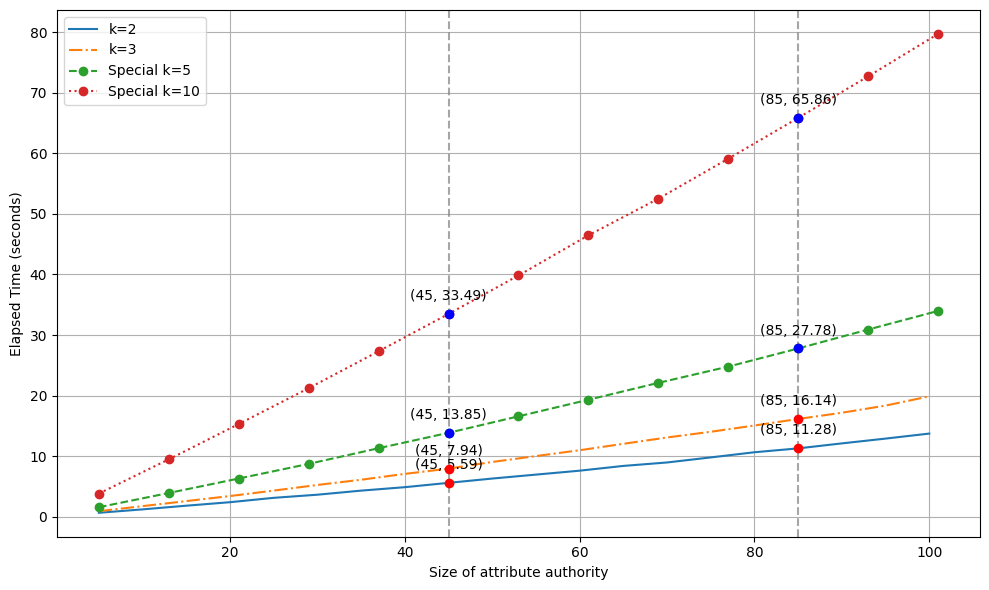

In [129]:
xs = range(5,101,5)
k_values = [2,3]

ys = []
ys.append([sum(pair[0]) for pair in data_2])
ys.append([sum(pair[0]) for pair in data_3])

sp_ks = [5,10]
sp_xs = range(5,102,8)
#data_5 = data_sp

sp_ys = []
sp_ys.append([sum(pair[0]) for pair in data_5])
sp_ys.append([sum(pair[0]) for pair in data_10])
plot_total_time_changes(xs, ys, k_values, sp_ks, sp_xs, sp_ys)

In [ ]:
data_5, data_10

In [111]:
k_values = [2,3]
#sys_key_gen_time = [pair[0][2] for pair in data_2]
ad_time = [pair[1][0] for pair in data_2]
ad_time_ = [pair[1][0] for pair in data_3]
ys = [ad_time, ad_time_]

xs = range(5,101,5)

In [114]:
def plot_key_dec_changes(xs, ys, k_values):
    # Plotting:
    plt.figure(figsize=(10,6))

    # List of linestyles for variation. You can extend this if needed.
    linestyles = ['-', '-.']
    #sp_linestyles = ['--',':']

    # Plotting the regular data points for each k_value
    for k, y, style in zip(k_values, ys, linestyles):
        plt.plot(xs, y, label=f'k={k}', linestyle=style)

    # # Plotting the special cases
    # for k, y, style in zip(sp_ks, sp_ys, sp_linestyles):
    #     plt.plot(sp_xs, y, linestyle=style, marker='o', label=f'Special k={k}')

    # Setting labels, title, legend, etc.
    plt.xlabel('Size of attribute authority')
    plt.ylabel('Elapsed Time (seconds)')
    #plt.title('Performance based on k-LIN Assumption Size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

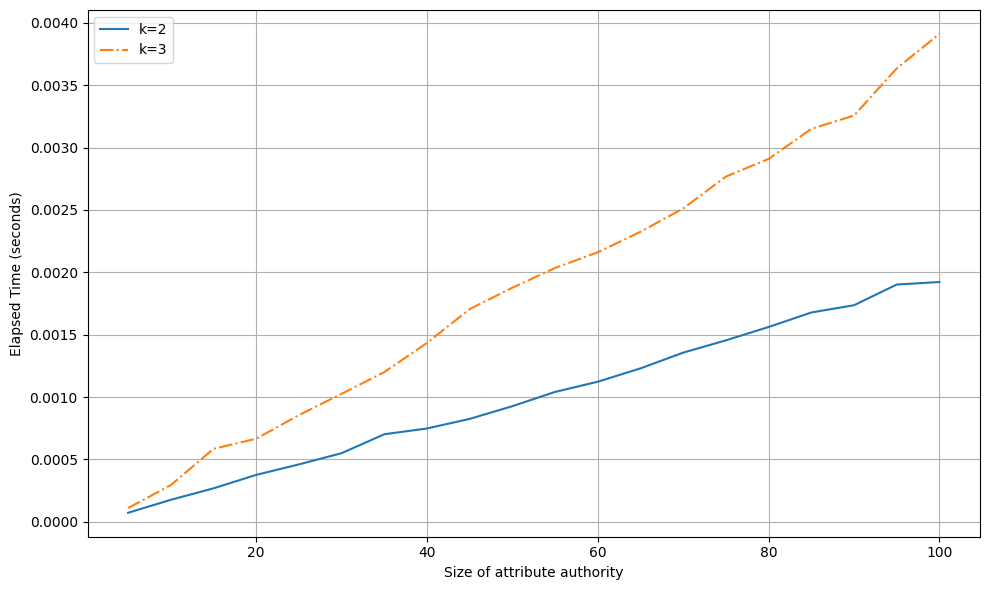

In [115]:
plot_key_dec_changes(xs, ys, k_values)

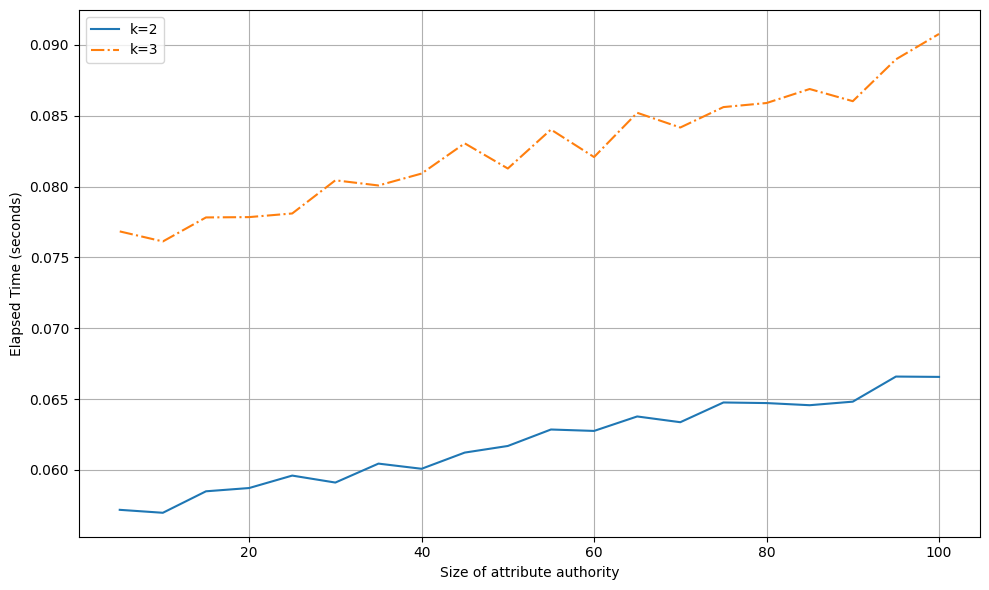

In [116]:
k_values = [2,3]
#sys_key_gen_time = [pair[0][2] for pair in data_2]
ad_time = [pair[1][1] for pair in data_2]
ad_time_ = [pair[1][1] for pair in data_3]
ys = [ad_time, ad_time_]

xs = range(5,101,5)

plot_key_dec_changes(xs, ys, k_values)

## NIZK

## Other 

In [ ]:
import math
def crack_policy(k):
    pp, msk = setup(k)

    g = pp['g_1']
    h = pp['g_2']
    e_gh = pp['e_g1_g2']
    g_A = pp['g_1^A']

    a = msk['a']
    A = msk['A']

    group = PairingGroup('MNT224')

    shift = group.random(ZR)
    U = [([0] * (k+1)) for i in range(k+1)]

    for j1 in range(k + 1): #col
        U[j1][j1] = shift

    UTA = []
    for j1 in range(k+1):
        y = []
        for j2 in range(k):
            l = A[j2] * U[j2][j1]
            r = U[k][j1]

            y.append(l + r)
        UTA.append(y)

    #g_WTA_ = [[g**ele for ele in y] for y in WTA]
    #print (g_WTA_)

    '''
    g_UTA = []
    for j1 in range(k+1):
        y = []
        for j2 in range(k):
            l = A[j2] * U[j2][j1]
            r = U[k][j1]

            y.append(g**(l + r))
        g_UTA.append(y)
    #print (g_WTA)
    #return
    '''
    s = []
    for i in range(k):
        s.append(group.random(ZR))

    As = []
    for i in range(k):
        As.append(A[i] * s[i])
    As.append(sum(s))

    #print ('s[2]?',A[2]*s[2]*a[2])
    #print ('s[2]!', s[2])
    #return

    ret = []
    for i in range(k+1):
        ret.append(As[i] * a[i])
    print ('As.dot(a):', ret)
    print ('Sum(As.dot(a):', sum(ret))
    #print (s)
    #print (g ** sum())
    #return sum(ret)

    UTAs = []
    for j1 in range(k+1): #row
        y = 0
        for j2 in range(k): #col
            y += UTA[j1][j2] * s[j2]
        UTAs.append(y)

    ret = []
    for i in range(k+1):
        ret.append(UTAs[i] * a[i])

    #print ([g**ele for ele in WTAs])
    print ('UTAsT.dot(a):', ret)
    print ('Sum(UTAsT.dot(a)):', sum(ret))

#-----------------------------------------------------------------------------------------------
    return

    g_WTAs = []
    for j1 in range(k+1):
        y = []
        for j2 in range(k):
            y.append(g_WTA[j1][j2] ** s[j2])

        g_WTAs.append(prod(y))

    WTAsa = []
    for i in range(k+1):
        WTAsa.append(WTAs[i]*a[i])
    return sum(WTAsa)

    #print ('original g_WTAs:\n',g_WTAs)
    #return
    tar = g_WTAs
    #tar = [list(i) for i in zip(*tar)]
    #print ('new g_WTAs:\n', tar)

    tmp = []
    for i in range(k+1):
        tmp.append(tar[i]**a[i])

    result = prod(tmp)
    print ('result: ', result)

    res = []
    tmp = g_A
    tmp.append(g)
    for i in range(k+1):
        res.append(tmp[i] ** a[i])
    res = prod(tmp)
    print ('exp: ', res)
    print ('g:', g)


In [ ]:
rows, cols = 3,6
[([0]*cols) for i in range(rows)]

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]

In [ ]:
crack_policy(5)

As.dot(a): [3470193020645640607344724949730565120811239487105599444988578077007, 10080473044863080624960124401806853022803967443970865425571396259264, 11815136366209015615763018985970022156110285290173523277865584051105, 6343650328129861115438351437281923546048591910893059984187662567089, 2804519339262100236653226564867150322678910282937391048080019165503, 10572426742845405197107073012658169889296769817296122737196383465095]
Sum(As.dot(a): 0
UTAsT.dot(a): [1923544615086348798531410976189326180923007696766120283915460729362, 9877480327369708214919117008396679989016282997414126587472793260333, 4650946474027341706285284075507646812530987047209781241406716109721, 13098970507006637555224173492010209844441697302799630828730484131695, 12581527808407055592801518597771553446937981558628221012458130818748, 2953929110058011529505015202439267783899807629558681963906038535204]
Sum(UTAsT.dot(a)): 0


In [ ]:
 def prod(lst):
    product = 1
    for x in lst:
        product *=x

    return product

In [ ]:
prod([1,2,3,4])

24

In [ ]:
crack_policy(5)

As.dot(a): [14663164353575075816327719368048573247152273705540011374512010645433, 9516080211722022715381010444262914147348628621661773310098874065326, 13487610684255280001199021200143815246293163375495768285735644136821, 9163734690656439233335184762858245197496774524839942563694152397078, 7094797723350440801648365639168695551695189636865884850308896838160, 6189810792380879295130724388604002020346989112098702172836586697266]
Sum(As.dot(a): 0
UTAsT.dot(a): [5568849997804693179504669245907905892691982579246269968970697264634, 7826273768162944467552447839019124423336179475170111330653993898112, 5844956724580098697035034744652737273946224667429164438341880583418, 3972830284449545755478498967375863713380371954505814489768184530568, 3169096499883841496676818788559157151804833727782922650741863355829, 3675591953088945335263543316028334250006917084116758400116462757481]
Sum(UTAsT.dot(a)): 0


In [ ]:
g

[12370253121840854961011440556486136698821000374218479076824493569176, 9883798420876492190166395522046401287784061433558937541497147649293]

In [ ]:
pp, msk = setup(5)
e_gh = pp['e_g1_g2']
a = msk['a']
A = msk['A']
g_A = pp['g_1^A']
g = pp['g_1']


ret = []
for i in range(5):
    ret.append(g_A[i]**a[i] * g ** a[5])
ret

[O, O, O, O, O]

In [ ]:
#n size of universal attributes
def encrypt(pp, pks, n, x, msg, k, groupObj = PairingGroup('MNT224')):
    group = groupObj

    g = pp['g_1']
    h = pp['g_2']
    e_gh = pp['e_g1_g2']
    g_A = pp['g_1^A']
    g_UTA = pp['g_1^{U^T A}']

    s = []
    for i in range(k):
        s.append(group.random(ZR))

    xs = []
    for i in range(n):
        xs.append([x[i] * ele for ele in s])

    C0 = []
    for i in range(k):
        C0.append(g_A[i] ** s[i])
    C0.append(g**sum(s))

    C1 = []



    x = []
    for i in range(n):


In [ ]:
g = group.random(G1)
h = group.random(G2)
s = group.random(ZR)
msg = pairing_group.random(GT)
print ('msg: ', msg)
ctext = msg * pair(g, h)**5
print ('ctext: ', ctext)

msg:  [[14590744609724053954243132720055950724167746956874546185919098238093, 7044598617208218796378413188130011989566854314370845990066843412294, 14616142705794054377368110643750255908550875532587478547715502303432], [10829564121571227711601234441501797991363085247925269634487679338788, 2507613797895301148510724870362602011775715126956769347290797383128, 354782065459314935909819536481523358787711415582566408311356045721]]
ctext:  [[1806014638930345288307913923436173978155521575493455472602792815837, 13736497451236196346059719775405698948063459947769331176689647692483, 10074907065816467167707575577339237020532267558207735459286045928983], [2941538304991490030986972885344585527903748236961128644698028224275, 11158361292092928253861778997824034338570900747149389152150898981174, 6544250775863161195962549022632743468816373080547796882360799562899]]


In [ ]:
p = group.random(ZR)
a = group.random(ZR)
t1 = pair(pair(g**p, h**a), h)
t2 = pair(g**p, h**a)
print ('t1: ', t1)
print ('t2: ', t2)

t1:  [[1, 0, 0], [0, 0, 0]]
t2:  [[10429219464470294457781921434836029054308356722107645896743812780795, 477147065968451196441085894986811611681142975101139268866625680387, 4328665428551831603791707415291487752222550890878022747872262509339], [8576466023134786858509856049677341857883022255569461387652751239012, 8662024698907056378232243465629603888080195409468495538674318644717, 12861408157509802975244696829216283378639950248109248669026773556813]]


In [ ]:
ctext ** 0

[[1, 0, 0], [0, 0, 0]]

In [ ]:
tmp ** (1/s)

[[3233876151552662863808257166469074151727419564594470806952727426786, 1977675586281160154039587388378873303894507086911133008955357627811, 10197494939872944424383326471184372308260205381927560960621721399251], [9780577947408549572662475597179255178089613744402102710208920284002, 408851198913964522235376317082092999652243040562955715762477590906, 3476129419762111705202598186903462609177730753974004489981865859661]]

In [ ]:
x = []
#j1: col, j2: row
for j1 in range(assump_size + 1): #assump_size = k
    y = []
    for j2 in range(assump_size):
        prod = (A[j2] * W[j2][j1]) + W[assump_size][j1] # simple version of mat * mat
        y.append(g ** prod)
    x.append(y)

[[6206581856385479420601522786370681598527265848325182650886728356955, 7926720559979193195152877774997005683006222879661834436154516137424, 3074117153912630898205454418719569700910661257467954555634380037004], [3824458037668158322118133145800044484591026722224686780074825387633, 3724595522168987851809577091005966685092743429673442533550835346053, 6090663939188751273182568575395491936718718561050669393164489652630]]

In [ ]:
class CGW15CPABE(ABEnc):
    def __init__(self, groupObj, assump_size, uni_size, verbose=False):
        ABEnc.__init__(self)
        self.group = groupObj
        self.assump_size = assump_size  # size of the linear assumption
        self.uni_size = uni_size  # bound on the size of the universe of attributes
        self.util = MSP(self.group, verbose)

    def setup(self):
        """
        Generates public key and master secret key.
        """

        if debug:
            print('Setup algorithm:\n')

        # generate two instances of the k-linear assumption
        A = []
        B = []
        for i in range(self.assump_size):
            A.append(self.group.random(ZR))
            B.append(self.group.random(ZR))  # note that A, B are vectors here

        # pick matrices that help to randomize basis
        W = {}
        for i in range(self.uni_size):
            x = []
            for j1 in range(self.assump_size + 1):
                y = []
                for j2 in range(self.assump_size + 1):
                    y.append(self.group.random(ZR))
                x.append(y)
            W[i + 1] = x

        V = []
        for j1 in range(self.assump_size + 1):
            y = []
            for j2 in range(self.assump_size + 1):
                y.append(self.group.random(ZR))
            V.append(y)

        # vector
        k = []
        for i in range(self.assump_size + 1):
            k.append(self.group.random(ZR))

        # pick a random element from the two source groups and pair them
        g = self.group.random(G1)
        h = self.group.random(G2)
        e_gh = pair(g, h)

        # now compute various parts of the public parameters

        # compute the [A]_1 term
        g_A = []
        for i in range(self.assump_size):
            g_A.append(g ** A[i])
        g_A.append(g)

        # compute the [W_1^T A]_1, [W_2^T A]_1, ...  terms
        g_WA = {}
        for i in range(self.uni_size):
            x = []
            for j1 in range(self.assump_size + 1):
                y = []
                for j2 in range(self.assump_size):
                    prod = (A[j2] * W[i + 1][j2][j1]) + W[i + 1][self.assump_size][j1]
                    y.append(g ** prod)
                x.append(y)
            g_WA[i + 1] = x

        g_VA = []
        for j1 in range(self.assump_size + 1):
            y = []
            for j2 in range(self.assump_size):
                prod = (A[j2] * V[j2][j1]) + V[self.assump_size][j1]
                y.append(g ** prod)
            g_VA.append(y)

        # compute the e([A]_1, [k]_2) term
        h_k = []
        for i in range(self.assump_size + 1):
            h_k.append(h ** k[i])

        e_gh_kA = []
        for i in range(self.assump_size):
            e_gh_kA.append(e_gh ** (k[i] * A[i] + k[self.assump_size]))

        # the public key
        pk = {'g_A': g_A, 'g_WA': g_WA, 'g_VA': g_VA, 'e_gh_kA': e_gh_kA}

        # the master secret key
        msk = {'h': h, 'k': k, 'B': B, 'W': W, 'V': V}

        return pk, msk

    def keygen(self, pk, msk, attr_list):
        """
        Generate a key for a set of attributes.
        """

        if debug:
            print('Key generation algorithm:\n')

        # pick randomness
        r = []
        sum = 0
        for i in range(self.assump_size):
            rand = self.group.random(ZR)
            r.append(rand)
            sum += rand

        # compute the [Br]_2 term
        K_0 = []
        Br = []
        h = msk['h']
        for i in range(self.assump_size):
            prod = msk['B'][i] * r[i]
            Br.append(prod)
            K_0.append(h ** prod)
        Br.append(sum)
        K_0.append(h ** sum)

        # compute the [W_i^T Br]_2 terms
        K = {}
        for attr in attr_list:
            key = []
            W_attr = msk['W'][int(attr)]
            for j1 in range(self.assump_size + 1):
                sum = 0
                for j2 in range(self.assump_size + 1):
                    sum += W_attr[j1][j2] * Br[j2]
                key.append(h ** sum)
            K[attr] = key

        # compute the [k + VBr]_2 term
        Kp = []
        V = msk['V']
        k = msk['k']
        for j1 in range(self.assump_size + 1):
            sum = 0
            for j2 in range(self.assump_size + 1):
                sum += V[j1][j2] * Br[j2]
            Kp.append(h ** (k[j1] + sum))

        return {'attr_list': attr_list, 'K_0': K_0, 'K': K, 'Kp': Kp}

    def encrypt(self, pk, msg, policy_str):
        """
        Encrypt a message M under a policy string.
        """

        if debug:
            print('Encryption algorithm:\n')

        policy = self.util.createPolicy(policy_str)
        mono_span_prog = self.util.convert_policy_to_msp(policy)
        num_cols = self.util.len_longest_row

        # pick randomness
        s = []
        sum = 0
        for i in range(self.assump_size):
            rand = self.group.random(ZR)
            s.append(rand)
            sum += rand
        s.append(sum)

        # compute the [As]_1 term
        g_As = []
        g_A = pk['g_A']
        for i in range(self.assump_size + 1):
            g_As.append(g_A[i] ** s[i])

        # compute U^T_2 As, U^T_3 As by picking random matrices U_2, U_3 ...
        UAs = {}
        for i in range(num_cols - 1):
            x = []
            for j1 in range(self.assump_size + 1):
                prod = 1
                for j2 in range(self.assump_size + 1):
                    prod *= g_As[j2] ** (self.group.random(ZR))
                x.append(prod)
            UAs[i+1] = x

        # compute V^T As using VA from public key
        VAs = []
        g_VA = pk['g_VA']
        for j1 in range(self.assump_size + 1):
            prod = 1
            for j2 in range(self.assump_size):
                prod *= g_VA[j1][j2] ** s[j2]
            VAs.append(prod)

        # compute the [(V^T As||U^T_2 As||...||U^T_cols As) M^T_i + W^T_i As]_1 terms
        C = {}
        g_WA = pk['g_WA']
        for attr, row in mono_span_prog.items():
            attr_stripped = self.util.strip_index(attr)  # no need, re-use not allowed
            ct = []
            for j1 in range(self.assump_size + 1):
                cols = len(row)
                prod1 = VAs[j1] ** row[0]
                for j2 in range(1, cols):
                    prod1 *= UAs[j2][j1] ** row[j2]
                prod2 = 1
                for j2 in range(self.assump_size):
                    prod2 *= g_WA[int(attr_stripped)][j1][j2] ** s[j2]
                ct.append(prod1 * prod2)
            C[attr] = ct

        # compute the e(g, h)^(k^T As) . m term
        Cx = 1
        for i in range(self.assump_size):
            Cx = Cx * (pk['e_gh_kA'][i] ** s[i])
        Cx = Cx * msg

        return {'policy': policy, 'C_0': g_As, 'C': C, 'Cx': Cx}

    def decrypt(self, pk, ctxt, key):
        """
        Decrypt ciphertext ctxt with key key.
        """

        if debug:
            print('Decryption algorithm:\n')

        nodes = self.util.prune(ctxt['policy'], key['attr_list'])
        if not nodes:
            print ("Policy not satisfied.")
            return None

        prod1_GT = 1
        prod2_GT = 1
        for i in range(self.assump_size + 1):
            prod_H = 1
            prod_G = 1
            for node in nodes:
                attr = node.getAttributeAndIndex()
                attr_stripped = self.util.strip_index(attr)  # no need, re-use not allowed
                # prod_H *= D['K'][attr_stripped][i] ** coeff[attr]
                # prod_G *= E['C'][attr][i] ** coeff[attr]
                prod_H *= key['K'][attr_stripped][i]
                prod_G *= ctxt['C'][attr][i]
            prod1_GT *= pair(ctxt['C_0'][i], key['Kp'][i] * prod_H)
            prod2_GT *= pair(prod_G, key['K_0'][i])

        return ctxt['Cx'] * prod2_GT / prod1_GT


In [ ]:
class AC17CPABE(ABEnc):
    def __init__(self, group_obj, assump_size, verbose=False):
        ABEnc.__init__(self)
        self.group = group_obj
        self.assump_size = assump_size  # size of linear assumption, at least 2
        self.util = MSP(self.group, verbose)

    def setup(self):
        """
        Generates public key and master secret key.
        """

        if debug:
            print('\nSetup algorithm:\n')

        # generate two instances of the k-linear assumption
        A = []
        B = []
        for i in range(self.assump_size):
            A.append(self.group.random(ZR))
            B.append(self.group.random(ZR))  # note that A, B are vectors here

        # vector
        k = []
        for i in range(self.assump_size + 1):
            k.append(self.group.random(ZR))

        # pick a random element from the two source groups and pair them
        g = self.group.random(G1)
        h = self.group.random(G2)
        e_gh = pair(g, h)

        # now compute various parts of the public parameters

        # compute the [A]_2 term
        h_A = []
        for i in range(self.assump_size):
            h_A.append(h ** A[i])
        h_A.append(h)

        # compute the e([k]_1, [A]_2) term
        g_k = []
        for i in range(self.assump_size + 1):
            g_k.append(g ** k[i])

        e_gh_kA = []
        for i in range(self.assump_size):
            e_gh_kA.append(e_gh ** (k[i] * A[i] + k[self.assump_size]))

        # the public key
        pk = {'h_A': h_A, 'e_gh_kA': e_gh_kA}

        # the master secret key
        msk = {'g': g, 'h': h, 'g_k': g_k, 'A': A, 'B': B}

        return pk, msk

    def keygen(self, pk, msk, attr_list):
        """
        Generate a key for a list of attributes.
        """

        if debug:
            print('\nKey generation algorithm:\n')

        # pick randomness
        r = []
        sum = 0
        for i in range(self.assump_size):
            rand = self.group.random(ZR)
            r.append(rand)
            sum += rand

        # compute the [Br]_2 term

        # first compute just Br as it will be used later too
        Br = []
        for i in range(self.assump_size):
            Br.append(msk['B'][i] * r[i])
        Br.append(sum)

        # now compute [Br]_2
        K_0 = []
        for i in range(self.assump_size + 1):
            K_0.append(msk['h'] ** Br[i])

        # compute [W_1 Br]_1, ...
        K = {}
        A = msk['A']
        g = msk['g']
        for attr in attr_list:
            key = []
            sigma_attr = self.group.random(ZR)
            for t in range(self.assump_size):
                prod = 1
                a_t = A[t]
                for l in range(self.assump_size + 1):
                    input_for_hash = attr + str(l) + str(t)
                    prod *= (self.group.hash(input_for_hash, G1) ** (Br[l]/a_t))
                prod *= (g ** (sigma_attr/a_t))
                key.append(prod)
            key.append(g ** (-sigma_attr))
            K[attr] = key

        # compute [k + VBr]_1
        Kp = []
        g_k = msk['g_k']
        sigma = self.group.random(ZR)
        for t in range(self.assump_size):
            prod = g_k[t]
            a_t = A[t]
            for l in range(self.assump_size + 1):
                input_for_hash = '01' + str(l) + str(t)
                prod *= (self.group.hash(input_for_hash, G1) ** (Br[l] / a_t))
            prod *= (g ** (sigma / a_t))
            Kp.append(prod)
        Kp.append(g_k[self.assump_size] * (g ** (-sigma)))

        return {'attr_list': attr_list, 'K_0': K_0, 'K': K, 'Kp': Kp}

    def encrypt(self, pk, msg, policy_str):
        """
        Encrypt a message msg under a policy string.
        """

        if debug:
            print('\nEncryption algorithm:\n')

        policy = self.util.createPolicy(policy_str)
        mono_span_prog = self.util.convert_policy_to_msp(policy)
        num_cols = self.util.len_longest_row

        # pick randomness
        s = []
        sum = 0
        for i in range(self.assump_size):
            rand = self.group.random(ZR)
            s.append(rand)
            sum += rand

        # compute the [As]_2 term
        C_0 = []
        h_A = pk['h_A']
        for i in range(self.assump_size):
            C_0.append(h_A[i] ** s[i])
        C_0.append(h_A[self.assump_size] ** sum)

        # compute the [(V^T As||U^T_2 As||...) M^T_i + W^T_i As]_1 terms

        # pre-compute hashes
        hash_table = []
        for j in range(num_cols):
            x = []
            input_for_hash1 = '0' + str(j + 1)
            for l in range(self.assump_size + 1):
                y = []
                input_for_hash2 = input_for_hash1 + str(l)
                for t in range(self.assump_size):
                    input_for_hash3 = input_for_hash2 + str(t)
                    hashed_value = self.group.hash(input_for_hash3, G1)
                    y.append(hashed_value)
                    # if debug: print ('Hash of', i+2, ',', j2, ',', j1, 'is', hashed_value)
                x.append(y)
            hash_table.append(x)

        C = {}
        for attr, row in mono_span_prog.items():
            ct = []
            attr_stripped = self.util.strip_index(attr)  # no need, re-use not allowed
            for l in range(self.assump_size + 1):
                prod = 1
                cols = len(row)
                for t in range(self.assump_size):
                    input_for_hash = attr_stripped + str(l) + str(t)
                    prod1 = self.group.hash(input_for_hash, G1)
                    for j in range(cols):
                        # input_for_hash = '0' + str(j+1) + str(l) + str(t)
                        prod1 *= (hash_table[j][l][t] ** row[j])
                    prod *= (prod1 ** s[t])
                ct.append(prod)
            C[attr] = ct

        # compute the e(g, h)^(k^T As) . m term
        Cp = 1
        for i in range(self.assump_size):
            Cp = Cp * (pk['e_gh_kA'][i] ** s[i])
        Cp = Cp * msg

        return {'policy': policy, 'C_0': C_0, 'C': C, 'Cp': Cp}

    def decrypt(self, pk, ctxt, key):
        """
        Decrypt ciphertext ctxt with key key.
        """

        if debug:
            print('\nDecryption algorithm:\n')

        nodes = self.util.prune(ctxt['policy'], key['attr_list'])
        if not nodes:
            print ("Policy not satisfied.")
            return None

        prod1_GT = 1
        prod2_GT = 1
        for i in range(self.assump_size + 1):
            prod_H = 1
            prod_G = 1
            for node in nodes:
                attr = node.getAttributeAndIndex()
                attr_stripped = self.util.strip_index(attr)  # no need, re-use not allowed
                # prod_H *= key['K'][attr_stripped][i] ** coeff[attr]
                # prod_G *= ctxt['C'][attr][i] ** coeff[attr]
                prod_H *= key['K'][attr_stripped][i]
                prod_G *= ctxt['C'][attr][i]
            prod1_GT *= pair(key['Kp'][i] * prod_H, ctxt['C_0'][i])
            prod2_GT *= pair(prod_G, key['K_0'][i])

        return ctxt['Cp'] * prod2_GT / prod1_GT


In [ ]:
from charm.toolbox.pairinggroup import PairingGroup, GT

debug = True
# instantiate a bilinear pairing map
pairing_group = PairingGroup('MNT224')

# AC17 CP-ABE under DLIN (2-linear)
cpabe = AC17CPABE(pairing_group, 2,)

# run the set up
(pk, msk) = cpabe.setup()

# generate a key
attr_list = ['ONE', 'TWO', 'THREE']
key = cpabe.keygen(pk, msk, attr_list)

# choose a random message
msg = pairing_group.random(GT)
print ('msg:', msg)

# generate a ciphertext
policy_str = '((ONE and THREE) and (TWO OR FOUR))'
ctxt = cpabe.encrypt(pk, msg, policy_str)

# decryption
rec_msg = cpabe.decrypt(pk, ctxt, key)
if debug:
    if rec_msg == msg:
        print ("Successful decryption.")
    else:
        print ("Decryption failed.")


Setup algorithm:


Key generation algorithm:

msg: [[9782758510808858782463092981294579282847936674822051449404655841116, 526971871004176385871051263421858684642327246674972888667810985801, 1941428199729902338596099979674516259879064285681242342989698940354], [3179537818609894534007954240764538213233339768185552283569114911045, 7148980626112526615946304794263567977946052436147631840804066048209, 4980654066192165181579496144739565048230154769274513864394774903957]]

Encryption algorithm:


Decryption algorithm:

Successful decryption.
